<a href="https://colab.research.google.com/github/uwerrrr/text_major_project/blob/main/45817006_text_major_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook is for the major project submission for COMP8220, on the **language** dataset and task.  It contains the following main sections:

*   Preparation
*   Data transformation
*   Conventional ML models
*   Deep learning models
*   Discussion of Model Performance and Implementation


**Note:**


*   Each model section also contains observation part at the end which highlights my observation from the process of training the models.
*   Since this notebook is lengthy, it is suggested to use table of content sidebar for better navigation.







# Preparation

This section contains loading data into the notebook and some slight raw data exploration

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

os.chdir('./gdrive/MyDrive/Colab Notebooks/Project/')



['45817006_text_major_project.ipynb',
 'Project desc.pdf',
 ' Image Dataset Details.pdf',
 'Language Dataset Desc.pdf',
 'Code Snippets',
 'datasets',
 '.ipynb_checkpoints',
 'test',
 'models',
 '45817006-conv.csv',
 'glove.twitter.27B',
 'text_code_stub.ipynb',
 'model_3_2_best.h5',
 '45817006-private.csv',
 '45817006-deep.csv',
 'sample-notebook-template.ipynb',
 'Copy of 45817006_text_major_project.ipynb',
 'best_model.h5']

In [ ]:
# imports
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras import backend

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import keras.optimizers
from keras.utils import np_utils, to_categorical
from keras.models import Sequential, load_model
from keras.optimizers import Adadelta, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Input, TimeDistributed, Dropout, Conv1D, MaxPooling1D
from keras.layers import LSTM, SimpleRNN, Bidirectional, Masking, Activation, GRU
from keras.layers import Flatten, BatchNormalization, Embedding
from keras.preprocessing import sequence, text, sequence
from keras.preprocessing.text import Tokenizer, one_hot
from keras.utils import pad_sequences

from tensorflow.keras import regularizers

import fastai
from fastai import *
from fastai.text import *
from functools import partial
import io

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Load data

In [ ]:
def load_pickle(path):
    with open(path, 'rb') as f:
        file = pickle.load(f)
        print ('Loaded %s..' %path)
        return file

dataset_directory = 'datasets/text-data/'  ## CHANGE TO YOUR OWN DIRECTORY

emotions = ['anger', 'fear', 'joy', 'sadness']

tweets_train = np.load(join(dataset_directory, 'text_train_tweets.npy'))
labels_train = np.load(join(dataset_directory, 'text_train_labels.npy'))
vocabulary = load_pickle(join(dataset_directory, 'text_word_to_idx.pkl'))

tweets_val = np.load(join(dataset_directory, 'text_val_tweets.npy'))
labels_val = np.load(join(dataset_directory, 'text_val_labels.npy'))

tweets_test_public = np.load(join(dataset_directory, 'text_test_public_tweets_rand.npy'))
tweets_test_private = np.load(join(dataset_directory, 'text_test_private_tweets.npy'))

print(len(vocabulary))
idx_to_word = {i: w for w, i in vocabulary.items()}
for i in range(7):
  print(i, idx_to_word[i])

sample = 4  ## YOU CAN TRY OUT OTHER TWEETS

print('sample tweet, stored form:')
print(tweets_train[sample])
print(labels_train[sample])

print('sample tweet, readable form:')
decode = []
for i in range(50):
  decode.append(idx_to_word[tweets_train[sample][i]])
print(decode)
print(emotions[labels_train[sample]])


print('shape of tweets_train:', tweets_train.shape)
print('shape of labels_train:',labels_train.shape)
print('shape of tweets_val:',tweets_val.shape)
print('shape of labels_val:',labels_val.shape)
print('shape of tweets_test_public:',tweets_test_public.shape)
print('shape of tweets_test_private:',tweets_test_private.shape)



Loaded datasets/text-data/text_word_to_idx.pkl..
13978
0 <NULL>
1 <START>
2 <END>
3 it
4 makes
5 me
6 so
sample tweet, stored form:
[ 1 57 74 36 75 76 77 78 29 79 47 80 81 77 82 29 38 36 83 84 85 77 86  2
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
0
sample tweet, readable form:
['<START>', 'i', 'need', 'a', '🍱', 'sushi', 'date', '🍙', '<user>', '🍝', 'an', 'olive', 'guarded', 'date', '🧀', '<user>', 'and', 'a', '👊', '🏼', 'rockys', 'date', '🍕', '<END>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>']
anger
shape of tweets_train: (7098, 52)
shape of labels_train: (7098,)
shape of tweets_val: (1460, 52)
shape of labels_val: (1460,)
shape of tweets_test_public: (4064, 52)
shape of tweets_test_private: (4257, 52)


## Data exploration

In [ ]:
# transform to dataframe
df_labels_train = pd.DataFrame(labels_train)
df_labels_train.columns = ['labels']

# add emotion to df
emotion_labels = []
for i in df_labels_train.index:
  emotion_labels.append(emotions[labels_train[i]])

df_labels_train["emotions"] = emotion_labels

**Plot train data**

['anger', 'fear', 'joy', 'sadness']


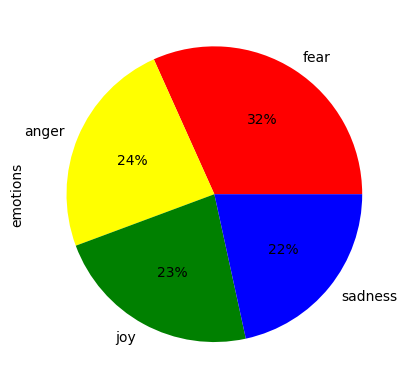

In [ ]:
df_labels_train.emotions.value_counts().plot(kind='pie', autopct='%1.0f%%',
                                         colors=["red", "yellow", "green","blue"])

print(emotions)

In [ ]:
print('counts of 4 labels: ')
df_labels_train.labels.value_counts()

counts of 4 labels: 


1    2251
0    1700
2    1615
3    1532
Name: labels, dtype: int64

-> Beside the fact that the number of *fear* tweet is higher than other emotions roughly 10%, the data is not very imbalanced.

**Checking the distribution of training set**

In [ ]:
print("labels of the first 10 sentences: ",labels_train[:10])
print("labels of the last 10 sentences: ",labels_train[len(labels_train)-10:len(labels_train)])

labels of the first 10 sentences:  [0 0 0 0 0 0 0 0 0 0]
labels of the last 10 sentences:  [3 3 3 3 3 3 3 3 3 3]


=> It is clearly that the training data is **sorted** and **not random**

---
# Transformation

According to the previous data exploration, the raw data is not random. Therefore, I decided to merge the raw data and split them into new train and validataion sets.

This section also contains text converting and cleaning process.
Because the given data still contains special characteristics such as emojis and `<words>`, I choose to convert the given data to text and remove all special characteristics and `<words>`.




In [ ]:
random_state = 42

### Merge and split train and validation sets

In [ ]:
tweets_new = np.concatenate((tweets_train, tweets_val))
labels_new = np.concatenate((labels_train, labels_val))
tweets_train_new, tweets_val_new, labels_train_new, labels_val_new = train_test_split(tweets_new, labels_new, test_size=0.15, random_state = random_state)

In [ ]:
print("labels of the first 10 sentences: ",labels_train_new[:10])
print("labels of the last 10 sentences: ",labels_train_new[len(labels_train_new)-10:len(labels_train_new)])
print("shape of labels_train_new:",labels_train_new.shape)
print("shape of tweets_train_new:",tweets_train_new.shape)
print('The first 10 sentences:')
tweets_train_new[:10]

labels of the first 10 sentences:  [0 1 0 0 1 2 3 2 2 3]
labels of the last 10 sentences:  [3 3 2 0 3 3 2 2 0 0]
shape of labels_train_new: (7274,)
shape of tweets_train_new: (7274, 52)
The first 10 sentences:


array([[    1,    29,    57,  1260,  1261,   997,   998,    97,   460,
         1262,     2,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    1,    64,    93,    36,   944,   532,   406,     2,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    1,   371,   205,   896,    20,   458,    51,  3024,  3025,
          122,   877,    26,   739,  3026,    35,    20,   733,    19,
           36,  3027,    50,  30

#### Check data balance


In [ ]:
# transform to dataframe
df_labels_train_new = pd.DataFrame(labels_train_new)
df_labels_train_new.columns = ['labels']

# add emotion to df
emotion_labels = []
for i in df_labels_train_new.index:
  emotion_labels.append(emotions[labels_train_new[i]])

df_labels_train_new["emotions"] = emotion_labels

**Plot train data**

['anger', 'fear', 'joy', 'sadness']


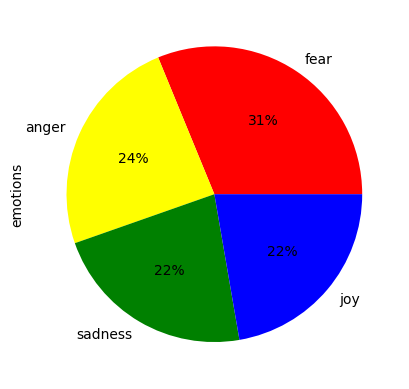

In [ ]:
df_labels_train_new.emotions.value_counts().plot(kind='pie', autopct='%1.0f%%',
                                         colors=["red", "yellow", "green","blue"])

print(emotions)

In [ ]:
print('counts of 4 labels: ')
df_labels_train_new.labels.value_counts()

counts of 4 labels: 


1    2270
0    1758
3    1625
2    1621
Name: labels, dtype: int64

In [ ]:
print("labels of the first 10 sentences: ",labels_train_new[:10])
print("labels of the last 10 sentences: ",labels_train_new[len(labels_train_new)-10:len(labels_train_new)])

labels of the first 10 sentences:  [0 1 0 0 1 2 3 2 2 3]
labels of the last 10 sentences:  [3 3 2 0 3 3 2 2 0 0]


#### Observation

After merging and splitting, new data shows same degree of balance as the original data.

The new data also shows randomness.

### Converting to text

Convert all data set to list containing sentences

In [ ]:
# function to convert a set to text
def convert_to_text(set):
  texts = []
  idx = len(set)
  vocab_list = list(vocabulary.keys())
  for i_t in range(idx):
    decode = []
    c_t = set[i_t]
    for w in range(52):
      if c_t[w] > 2: #or c_t[w]==0:      # not include <START> and <END> tags
        decode.append(vocab_list[c_t[w]])
    texts.append(decode)
  # texts=np.array(texts)
  # texts=np.array([np.array(xi) for xi in texts])

  # return texts

  text_set =[]
  for i in range(len(texts)):
    sen = ' '.join(word for word in texts[i])
    text_set.append(sen)

  return text_set

In [ ]:
tweets_train_t = convert_to_text(tweets_train_new)
tweets_val_t = convert_to_text(tweets_val_new)
tweets_test_public_t = convert_to_text(tweets_test_public)
tweets_test_private_t = convert_to_text(tweets_test_private)

In [ ]:
print('type of tweets_train_t:', type(tweets_train_t[:5]))
print('The first 10 sentences:')
tweets_train_t[:10]

type of tweets_train_t: <class 'list'>
The first 10 sentences:


['<user> i accidetly dumped boiling water my myself 😫',
 'you are a terrible time 😂',
 'did we miss the fact that #burkeramsey swung & hit his sister #jonbenet in the face with a golf club previously out of a fit of',
 '<user> <user> very heading not to mention an agenda driven article',
 '<user> horrible service ewr not a cloud in the sky normal departure at <time> now leaving at <time> crappy #unitedairlines',
 '“ when we give cheerfully and accept gratefully everyone is blessed ” ― maya angelou',
 'ffs clan seriously never been so disheartened',
 'the best part of this day jesus is to snuggle up in your embraceto rest in your arms and know you love me 💙 ❤ #sweetembrace #delight',
 "sometimes you just need to eat a delicious piece of chocolate to remind yourself that there ' s no need to be bitter sweetness",
 '<user> <user> trump presidency - a dark age for the usa and the world he would most definitely take us to war short & long term pain']

### Cleaning text sets

In [ ]:
# Function to remove all the special characters
import string

def clean(set):
  processed_features = []


  for sentence in range(0, len(set)):


    # remove <words>
    processed_feature = re.sub(r'<[a-zA-Z0-9]+>', ' ', str(set[sentence]))

    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', processed_feature)

    # remove some special characters
    processed_feature = re.sub(r"[!#$%•&\'()*+,-./:;=?“”_^\\`{|}~]", " ", processed_feature)

    # remove all single characters
    processed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

  return processed_features

In [ ]:
processed_tweets_train_t = clean(tweets_train_t)
processed_tweets_val_t = clean(tweets_val_t)
processed_tweets_test_public_t = clean(tweets_test_public_t)
processed_tweets_test_private_t = clean(tweets_test_private_t)

In [ ]:
print('type of tweets_train_t:', type(processed_tweets_train_t[:5]))
print('The first 10 sentences:')
processed_tweets_train_t[:10]

type of tweets_train_t: <class 'list'>
The first 10 sentences:


[' accidetly dumped boiling water my myself ',
 'you are terrible time ',
 'did we miss the fact that burkeramsey swung hit his sister jonbenet in the face with golf club previously out of fit of',
 ' very heading not to mention an agenda driven article',
 ' horrible service ewr not cloud in the sky normal departure at now leaving at crappy unitedairlines',
 ' when we give cheerfully and accept gratefully everyone is blessed maya angelou',
 'ffs clan seriously never been so disheartened',
 'the best part of this day jesus is to snuggle up in your embraceto rest in your arms and know you love me sweetembrace delight',
 'sometimes you just need to eat delicious piece of chocolate to remind yourself that there no need to be bitter sweetness',
 ' trump presidency dark age for the usa and the world he would most definitely take us to war short long term pain']

---
# Conventional machine learning

For conventional machine learning, I will use TF.IDF method to vectorize the cleaned texts before feeding them to the models.

I choose 4 conventional models to compare their efficiency.

1.   Naive Bayes Classifier
2.   Random Forest Classifier
3.   Logistic Regression model
4.   LinearSVC model




### TF.IDF - vectorzing text data

In [ ]:
vectorizer = TfidfVectorizer (
                              stop_words=stopwords.words('english')
                              )

In [ ]:
tfidf_tweets_train = vectorizer.fit_transform(processed_tweets_train_t).toarray()
tfidf_tweets_val = vectorizer.transform(processed_tweets_val_t).toarray()
tfidf_tweets_test_public = vectorizer.transform(processed_tweets_test_public_t).toarray()
tfidf_tweets_test_private = vectorizer.transform(processed_tweets_test_private_t).toarray()

In [ ]:
print('shape of tfidf_tweets_train:', tfidf_tweets_train.shape)

shape of tfidf_tweets_train: (7274, 11481)


## Variables

In [ ]:
X_train = tfidf_tweets_train
y_train = labels_train_new

X_val = tfidf_tweets_val
y_val = labels_val_new

X_test = tfidf_tweets_test_public
# X_test = tfidf_tweets_test_private

In [ ]:
print("The first 10 X_train: \n",X_train[:10])
print("\n The first 10 labels: \n",y_train[:10])

The first 10 X_train: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

 The first 10 labels: 
 [0 1 0 0 1 2 3 2 2 3]


In [ ]:
print("shape of X_train:", X_train.shape)
print("shape of y_train:",y_train.shape)
print("shape of X_val:",X_val.shape)
print("shape of y_val:",y_val.shape)
print("shape of X_test:",X_test.shape)

shape of X_train: (7274, 11481)
shape of y_train: (7274,)
shape of X_val: (1284, 11481)
shape of y_val: (1284,)
shape of X_test: (4064, 11481)


## Naive Bayes Classifier

In [ ]:
# train model
nb_clf = MultinomialNB()

nb_clf.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# make prediction
y_val_pred_nb = nb_clf.predict(X_val)
y_tr_pred_nb = nb_clf.predict(X_train)
y_test_pred_nb = nb_clf.predict(X_test)

### Evaluation

In [ ]:
print("score of val set",accuracy_score(y_val, y_val_pred_nb))
print("score of train set",accuracy_score(y_train, y_tr_pred_nb))

score of val set 0.7320872274143302
score of train set 0.8747594171020071


In [ ]:
print('confussion matrix')
print(confusion_matrix(y_val, y_val_pred_nb))

#            Predicted
#           0    1    2   3
# Actual 0
#        1
#        2
#        3

confussion matrix
[[238  65   7  19]
 [ 18 333   1  17]
 [  8  48 222   5]
 [ 41 111   4 147]]


In [ ]:
print('classification report:')
print(classification_report(y_val, y_val_pred_nb))

classification report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       329
           1       0.60      0.90      0.72       369
           2       0.95      0.78      0.86       283
           3       0.78      0.49      0.60       303

    accuracy                           0.73      1284
   macro avg       0.78      0.72      0.73      1284
weighted avg       0.77      0.73      0.73      1284



## Random Forest Classifier

In [ ]:
# Training RandomForest with 200 trees
rf_clf = RandomForestClassifier(n_estimators=200, random_state=random_state)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
# make prediction
y_val_pred_rf = rf_clf.predict(X_val)
y_tr_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

### Evaluation

In [ ]:
print("score of val set", accuracy_score(y_val, y_val_pred_rf))
print("score of train set", accuracy_score(y_train, y_tr_pred_rf))

score of val set 0.7484423676012462
score of train set 0.9206763816332142


In [ ]:
print('confussion matrix')
print(confusion_matrix(y_val, y_val_pred_rf))

#            Predicted
#           0    1    2   3
# Actual 0
#        1
#        2
#        3

confussion matrix
[[232  41  22  34]
 [ 29 282  18  40]
 [  6  26 247   4]
 [ 47  49   7 200]]


In [ ]:
print('classification report:')
print(classification_report(y_val, y_val_pred_rf))

classification report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       329
           1       0.71      0.76      0.74       369
           2       0.84      0.87      0.86       283
           3       0.72      0.66      0.69       303

    accuracy                           0.75      1284
   macro avg       0.75      0.75      0.75      1284
weighted avg       0.75      0.75      0.75      1284



## Logistic Regression

In [ ]:
log_clf = LogisticRegression(random_state=random_state)

log_clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
# make prediction
y_val_pred_log = log_clf.predict(X_val)
y_tr_pred_log = log_clf.predict(X_train)
y_test_pred_log = log_clf.predict(X_test)

### Evaluation

In [ ]:
print("score of val set", accuracy_score(y_val, y_val_pred_log))
print("score of train set", accuracy_score(y_train, y_tr_pred_log))

score of val set 0.7757009345794392
score of train set 0.8952433324168271


In [ ]:
print('confussion matrix')
print(confusion_matrix(y_val, y_val_pred_log))

#            Predicted
#           0    1    2   3
# Actual 0
#        1
#        2
#        3

confussion matrix
[[245  48   9  27]
 [ 21 315   8  25]
 [  9  27 242   5]
 [ 38  65   6 194]]


In [ ]:
print('classification report:')
print(classification_report(y_val, y_val_pred_log))

classification report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       329
           1       0.69      0.85      0.76       369
           2       0.91      0.86      0.88       283
           3       0.77      0.64      0.70       303

    accuracy                           0.78      1284
   macro avg       0.79      0.77      0.78      1284
weighted avg       0.78      0.78      0.78      1284



## LinearSVC

In [ ]:
svc_clf = LinearSVC()

svc_clf.fit(X_train, y_train)

LinearSVC()

In [ ]:
# make prediction
y_val_pred_svc = svc_clf.predict(X_val)
y_tr_pred_svc = svc_clf.predict(X_train)
y_test_pred_svc = svc_clf.predict(X_test)

### Evaluation

In [ ]:
print("score of val set", accuracy_score(y_val, y_val_pred_svc))
print("score of train set", accuracy_score(y_train, y_tr_pred_svc))

score of val set 0.7850467289719626
score of train set 0.9162771514984878


In [ ]:
print('confussion matrix')
print(confusion_matrix(y_val, y_val_pred_svc))

#            Predicted
#           0    1    2   3
# Actual 0
#        1
#        2
#        3

confussion matrix
[[252  40   4  33]
 [ 29 302   8  30]
 [  6  20 251   6]
 [ 44  49   7 203]]


In [ ]:
print('classification report:')
print(classification_report(y_val, y_val_pred_svc))

classification report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       329
           1       0.73      0.82      0.77       369
           2       0.93      0.89      0.91       283
           3       0.75      0.67      0.71       303

    accuracy                           0.79      1284
   macro avg       0.79      0.79      0.79      1284
weighted avg       0.79      0.79      0.78      1284



## Observation

From the evaluations, between the chosen 4 models, LinearSVC model gives the best accuracy score on validation sets:

**0.785**

---
# Deep machine learning

Since the best accuracy score on validation sets using Conventional models is **0.785**, the goal of deep models is to achieve a higher score.

There are two main trial in this section:
* The first trial is to build a neuron network and take the previous generated TF.IDF vectors as training data.

* The second trial is to build neuron networks using embedinng layer.








## Preparation



###Convert labels to one-hot encoding vectors
Neuron networks train most effectively when labels are one-hot encoding vectors. Thus, the training and validation labels encoded into one-hot encoding vector in this section.

In [ ]:
# convert labels to one-hot encoding vectors:
num_classes = len(emotions)    # number of classes
vec_labels_train = np_utils.to_categorical(labels_train_new, num_classes)
vec_labels_val = np_utils.to_categorical(labels_val_new, num_classes)

In [ ]:
print("labels of the first 5 sentences: ")
vec_labels_train[:5]

labels of the first 5 sentences: 


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

### Set up EarlyStopping and ModelCheckpoint

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

mcp_save = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='min')

### Prediction function

In [ ]:
def make_prediction(model, X_test):
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  return y_pred

## First trial - NN with TF.IDF



### Variables

In [ ]:
X_train = tfidf_tweets_train
y_train = vec_labels_train

X_val = tfidf_tweets_val
y_val = vec_labels_val

X_test = tfidf_tweets_test_public
# X_test = tfidf_tweets_test_private

print("X_train shape = ", X_train.shape)
print("y_train shape = ", y_train.shape)
print("X_val shape = ", X_val.shape)
print("y_val shape = ", y_val.shape)
print("X_test shape = ", X_test.shape)



X_train shape =  (7274, 11481)
y_train shape =  (7274, 4)
X_val shape =  (1284, 11481)
y_val shape =  (1284, 4)
X_test shape =  (4064, 11481)


In [ ]:
input_shape = X_train.shape[1:]
print("input_shape = ", input_shape)

input_dim = len(X_train[0])
print("input_dim = ", input_dim)

input_shape =  (11481,)
input_dim =  11481


### Training model

In [ ]:
model_tfidf = Sequential()

model_tfidf.add(Dense(128, activation='relu', input_dim=input_dim))
model_tfidf.add(Dropout(0.25))

model_tfidf.add(Dense(32, activation='relu'))
model_tfidf.add(Dropout(0.25))


model_tfidf.add(Dense(32, activation='relu'))
model_tfidf.add(Dropout(0.25))

model_tfidf.add(Dense(4, activation='softmax'))

model_tfidf.summary

model_tfidf.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_tfidf.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=[
                               earlyStopping,
                               mcp_save,
                               reduce_lr_loss]
          )

Epoch 1/20
228/228 [==============================] - 8s 10ms/step - loss: 1.2013 - accuracy: 0.4644 - val_loss: 0.7348 - val_accuracy: 0.7555 - lr: 0.0010
Epoch 2/20
228/228 [==============================] - 1s 5ms/step - loss: 0.5637 - accuracy: 0.8225 - val_loss: 0.6720 - val_accuracy: 0.7555 - lr: 0.0010
Epoch 3/20
225/228 [============================>.] - ETA: 0s - loss: 0.3599 - accuracy: 0.8811
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
228/228 [==============================] - 1s 6ms/step - loss: 0.3613 - accuracy: 0.8807 - val_loss: 0.7177 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 4/20
224/228 [============================>.] - ETA: 0s - loss: 0.2583 - accuracy: 0.9082
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
228/228 [==============================] - 1s 6ms/step - loss: 0.2570 - accuracy: 0.9090 - val_loss: 0.7305 - val_accuracy: 0.7531 - lr: 1.0000e-04
Epoch 5/20
216/228 [===========================>..]

In [ ]:
model_tfidf = load_model('best_model.h5')
print('Evaluation of model_tfidf:',model_tfidf.evaluate(x=X_val, y=y_val))

41/41 [==============================] - 0s 3ms/step - loss: 0.6720 - accuracy: 0.7555
Evaluation of model_tfidf: [0.6719509363174438, 0.7554517388343811]


In [ ]:
y_pred_tfidf = make_prediction(model_tfidf, X_test)

127/127 [==============================] - 0s 2ms/step


In [ ]:
backend.clear_session()

### Observation



The validation accuracy is stil around 0.78

**-> We can see that using NN with TF.IDF does not improve the accuracy on validation set**

## Second trial - NNs with embedding layer

Since using the training data processed with TF.IDF method does not improve the accuracy on validation set, this section considers training NNs with the cleaned text data and using embedding layer in the NN.

I also consider using a pre-trained embeding vector in this section.

### Convert text to vectors

In order to input the cleaned text data into embeding layer of the NN, the data needs to be converted into vectors.

In [ ]:
# iterate through each sentence in the corpus and then tokenize the sentence into words
def vectorize_text(X_train, X_val, X_test, X_test_pri):
  from keras.preprocessing.text import Tokenizer
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(X_train)

  word_index = tokenizer.word_index
  vocab_length = len(word_index) + 1


  X_train_vec = tokenizer.texts_to_sequences(X_train)
  X_val_vec = tokenizer.texts_to_sequences(X_val)
  X_test_vec = tokenizer.texts_to_sequences(X_test)
  X_test_pri_vec = tokenizer.texts_to_sequences(X_test_pri)

  X_train_vec_pad = pad_sequences(X_train_vec, len(tweets_train[0]), padding='post')
  X_val_vec_pad = pad_sequences(X_val_vec, len(tweets_train[0]), padding='post')
  X_test_vec_pad = pad_sequences(X_test_vec, len(tweets_train[0]), padding='post')
  X_test_pri_vec_pad = pad_sequences(X_test_pri_vec, len(tweets_train[0]), padding='post')

  return X_train_vec_pad, X_val_vec_pad, X_test_vec_pad, X_test_pri_vec_pad, vocab_length, word_index

In [ ]:
vec_tweets_train, vec_tweets_val, vec_tweets_test_public, vec_tweets_test_private, vocab_length, vocab = vectorize_text(processed_tweets_train_t,
                                                                                                                        processed_tweets_val_t,
                                                                                                                        processed_tweets_test_public_t,
                                                                                                                        processed_tweets_test_private_t)

print("shape of vec_tweets_train:", vec_tweets_train.shape)
print("shape of vec_tweets_val:", vec_tweets_val.shape)
print("shape of vec_tweets_test_public:", vec_tweets_test_public.shape)
print("shape of vec_tweets_test_private:", vec_tweets_test_private.shape)

shape of vec_tweets_train: (7274, 52)
shape of vec_tweets_val: (1284, 52)
shape of vec_tweets_test_public: (4064, 52)
shape of vec_tweets_test_private: (4257, 52)


In [ ]:
print('The first 5 labels:')
vec_tweets_train[:5]

The first 5 labels:


array([[6111, 2317,  431,  492,   10,  256,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   4,   17,  175,   54,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [  69,   36,  356,    1,  464,   11, 6112, 2889,  612,   56, 1149,
        6113,    9,    1,  240,   22, 6114, 1266, 6115,   44,    6, 2890,
           6,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0

### Variables

For this section, I create two groups of variables for comparisions to clarify whether I preporcessed the data too much or not.

*   Original variables: are from the given data *(after merging and splitting)*;
*   Processed variables are from the processed data





**Original variables**

In [ ]:
num_words_ori = len(vocabulary)
tweet_length_ori = len(tweets_train_new[0])
vocab_ori = vocabulary
print('num_classes =', num_classes)
print('num_words_ori =', num_words_ori)
print('tweet_length_ori =', tweet_length_ori)

num_classes = 4
num_words_ori = 13978
tweet_length_ori = 52


In [ ]:
X_train_ori = tweets_train_new
y_train = np.asarray(vec_labels_train)

X_val_ori = tweets_val_new
y_val = np.asarray(vec_labels_val)

X_test_ori = tweets_test_public
# X_test_ori = tweets_test_private

print("shape of X_train_ori:", X_train_ori.shape)
print("shape of y_train:",y_train.shape)
print("shape of X_val_ori:",X_val_ori.shape)
print("shape of y_val:",y_val.shape)
print("shape of X_test_ori:",X_test_ori.shape)

shape of X_train_ori: (7274, 52)
shape of y_train: (7274, 4)
shape of X_val_ori: (1284, 52)
shape of y_val: (1284, 4)
shape of X_test_ori: (4064, 52)


**Processed variables**

In [ ]:
num_words = vocab_length
tweet_length = len(vec_tweets_train[0])
vocab = vocab
print('num_classes =', num_classes)
print('num_words =', num_words)
print('tweet_length =', tweet_length)

num_classes = 4
num_words = 11654
tweet_length = 52


In [ ]:
X_train = vec_tweets_train
y_train = np.asarray(vec_labels_train)

X_val = vec_tweets_val
y_val = np.asarray(vec_labels_val)

X_test = vec_tweets_test_public
# X_test = vec_tweets_test_private

print("shape of X_train:", X_train.shape)
print("shape of y_train:",y_train.shape)
print("shape of X_val:",X_val.shape)
print("shape of y_val:",y_val.shape)
print("shape of X_test:",X_test.shape)

shape of X_train: (7274, 52)
shape of y_train: (7274, 4)
shape of X_val: (1284, 52)
shape of y_val: (1284, 4)
shape of X_test: (4064, 52)


### Set up GloVe Embeding vector

Because this is tweets dataset, I will use 200 dimensions pre-trained-on-tweets GloVe vectors. The file can be downloaded on [GloVe website](https://nlp.stanford.edu/projects/glove/).

In [ ]:
# load glove file
emb_dict = {}
glove_dim = 200
glove = open('glove.twitter.27B/glove.twitter.27B.200d.txt')

# add embedding vectors to emb_dict
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector

glove.close()

In [ ]:
# create embedding matrix with GloVe weight
def get_weight_matrix(num_words, vocab):
  emb_matrix = np.zeros((num_words, glove_dim))

  for w, i in vocab.items():    # only load the weight of existing words
      if i < num_words:
          vect = emb_dict.get(w)
          if vect is not None:
              emb_matrix[i] = vect
      else:
          break

  return emb_matrix


In [ ]:
emb_matrix_ori = get_weight_matrix(num_words_ori, vocab_ori)

emb_matrix = get_weight_matrix(num_words, vocab)

In [ ]:
embedding_vector_length = 200

In [ ]:
# create embedding_layer from GloVe weight
embedding_layer_Glo_ori = Embedding(input_dim = num_words_ori,
                            output_dim = embedding_vector_length,
                            # embeddings_initializer=Constant(emb_matrix_ori),
                            weights=[emb_matrix_ori],
                            input_length=tweet_length_ori,
                            trainable=False)

embedding_layer_Glo = Embedding(input_dim = num_words,
                            output_dim = glove_dim,
                            # embeddings_initializer=Constant(emb_matrix),
                            weights=[emb_matrix],
                            input_length=tweet_length,
                            trainable=False)



---

### NN models

There are 6 models in total depeending on the training data:


1.  Model using normal embeding layer with processed data
2.  Model using normal embeding layer with original data
3.  Model using GloVe embeding with processed data with `trainable = False`
4.  Model using GloVe embeding with processed data with `trainable = True`
5.  Model using GloVe embeding with original data with `trainable = False`
6.  Model using GloVe embeding with original data with `trainable = True`


**Note:** all models have the same architecture, the only difference lies on embeding weight and the training data


#### 1 Model using normal embeding layer with processed data

In [ ]:
embedding_vector_length = 200

In [ ]:
from keras.layers import Activation

model_1 = Sequential()

model_1.add(Embedding(input_dim = num_words,
                    output_dim = embedding_vector_length,
                    input_length = tweet_length))

model_1.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25,  kernel_regularizer=regularizers.l2(0.0001))))
model_1.add(LSTM(64, return_sequences=True, recurrent_dropout=0.25, dropout=0.25,  kernel_regularizer=regularizers.l2(0.0001)))

model_1.add(Conv1D(filters=64,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling1D(pool_size=2))

model_1.add(Dropout(0.25))

model_1.add(Conv1D(filters=64,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))


model_1.add(Conv1D(filters=32,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(GlobalMaxPooling1D())

model_1.add(Dense(32, activation='relu' , kernel_regularizer=regularizers.l2(0.0001) ))

model_1.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ))
model_1.add(Dropout(0.25))

model_1.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ))

model_1.add(Dense(num_classes, activation='softmax'))

model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 52, 200)           2330800   
                                                                 
 bidirectional (Bidirectiona  (None, 52, 256)          336896    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 52, 64)            82176     
                                                                 
 conv1d (Conv1D)             (None, 51, 64)            8256      
                                                                 
 batch_normalization (BatchN  (None, 51, 64)           256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 51, 64)            0

In [ ]:
model_1.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=[
                               earlyStopping,
                               mcp_save,
                               reduce_lr_loss,
                               ]
                    )


Epoch 1/20
228/228 [==============================] - 199s 793ms/step - loss: 1.4612 - accuracy: 0.2974 - val_loss: 1.4390 - val_accuracy: 0.2874 - lr: 0.0010
Epoch 2/20
228/228 [==============================] - ETA: 0s - loss: 1.3678 - accuracy: 0.3584
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
228/228 [==============================] - 170s 745ms/step - loss: 1.3678 - accuracy: 0.3584 - val_loss: 1.6782 - val_accuracy: 0.3092 - lr: 0.0010
Epoch 3/20
228/228 [==============================] - 166s 728ms/step - loss: 1.1517 - accuracy: 0.4720 - val_loss: 1.2159 - val_accuracy: 0.4377 - lr: 1.0000e-04
Epoch 4/20
228/228 [==============================] - 164s 721ms/step - loss: 1.1031 - accuracy: 0.4849 - val_loss: 1.1764 - val_accuracy: 0.4517 - lr: 1.0000e-04
Epoch 5/20
228/228 [==============================] - 163s 717ms/step - loss: 1.0714 - accuracy: 0.4999 - val_loss: 1.1679 - val_accuracy: 0.4564 - lr: 1.0000e-04
Epoch 6/20
228/228 [===========

In [ ]:
model_1 = load_model('best_model.h5')
print('Evaluation of model_1:',model_1.evaluate(x=X_val, y=y_val))

ValueError: ignored

In [ ]:
test1 = load_model('best_model.h5')
print('Evaluation of model_1:',test1.evaluate(x=X_val, y=y_val))

ValueError: ignored

In [ ]:
y_pred_1 = make_prediction(model_1,X_test)

In [ ]:
backend.clear_session()

#### 2 Model using normal embeding layer with original data

In [ ]:
from keras.layers import Activation

model_2 = Sequential()

model_2.add(Embedding(input_dim = num_words_ori,
                    output_dim = embedding_vector_length,
                    input_length = tweet_length_ori))

model_2.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25,  kernel_regularizer=regularizers.l2(0.0001))))

model_2.add(LSTM(64, return_sequences=True, recurrent_dropout=0.25, dropout=0.25,  kernel_regularizer=regularizers.l2(0.0001)))

model_2.add(Conv1D(filters=64,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling1D(pool_size=2))

model_2.add(Dropout(0.25))

model_2.add(Conv1D(filters=32,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))


model_2.add(Conv1D(filters=32,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(GlobalMaxPooling1D())

model_2.add(Dense(32, activation='relu' , kernel_regularizer=regularizers.l2(0.0001) ))

model_2.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ))
model_2.add(Dropout(0.25))

model_2.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ))

model_2.add(Dense(num_classes, activation='softmax'))

model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_2.summary()

In [ ]:
model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_2.fit(X_train_ori, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val_ori, y_val),
                    shuffle=True,
                    callbacks=[
                               earlyStopping,
                               mcp_save,
                               reduce_lr_loss
                               ])

In [ ]:
model_2 = load_model('best_model.h5')
print('Evaluation of model_2:', model_2.evaluate(x=X_val_ori, y=y_val))

In [ ]:
y_pred_2 = make_prediction(model_2,X_test_ori)

In [ ]:
backend.clear_session()

#### 3 Model using GloVe embeding with processed data

In [ ]:
from keras.layers import Activation

model_3_1 = Sequential()

model_3_1.add(embedding_layer_Glo)

model_3_1.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25,  kernel_regularizer=regularizers.l2(0.0001))))

model_3_1.add(LSTM(64, return_sequences=True, recurrent_dropout=0.25, dropout=0.25,  kernel_regularizer=regularizers.l2(0.0001)))

model_3_1.add(Conv1D(filters=64,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_3_1.add(BatchNormalization())
model_3_1.add(Activation('relu'))
model_3_1.add(MaxPooling1D(pool_size=2))

model_3_1.add(Dropout(0.25))

model_3_1.add(Conv1D(filters=64,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_3_1.add(BatchNormalization())
model_3_1.add(Activation('relu'))


model_3_1.add(Conv1D(filters=32,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_3_1.add(BatchNormalization())
model_3_1.add(Activation('relu'))

model_3_1.add(GlobalMaxPooling1D())

model_3_1.add(Dense(32, activation='relu' , kernel_regularizer=regularizers.l2(0.0001) ))

model_3_1.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ))
model_3_1.add(Dropout(0.25))

model_3_1.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ))

model_3_1.add(Dense(num_classes, activation='softmax'))

model_3_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_3_1.summary()

In [ ]:
model_3_1.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=[
                               earlyStopping,
                               mcp_save,
                               reduce_lr_loss
                               ]
                    )

In [ ]:
model_3_1 = load_model('best_model.h5')
print('Evaluation of model_3_1:',model_3_1.evaluate(x=X_val, y=y_val))

In [ ]:
y_pred_3_1 = make_prediction(model_3_1,X_test)

In [ ]:
backend.clear_session()

##### Set pre-trained embedding layer's trainable to True

In [ ]:
embedding_layer_Glo_T = Embedding(input_dim = num_words,
                            output_dim = glove_dim,
                            weights=[emb_matrix],
                            input_length=tweet_length,
                            trainable=True)

In [ ]:
from keras.layers import Activation

model_3_2 = Sequential()

model_3_2.add(embedding_layer_Glo_T)

model_3_2.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25,  kernel_regularizer=regularizers.l2(0.0001))))

model_3_2.add(LSTM(64, return_sequences=True, recurrent_dropout=0.25, dropout=0.25,  kernel_regularizer=regularizers.l2(0.0001)))

model_3_2.add(Conv1D(filters=64,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_3_2.add(BatchNormalization())
model_3_2.add(Activation('relu'))
model_3_2.add(MaxPooling1D(pool_size=2))

model_3_2.add(Dropout(0.25))

model_3_2.add(Conv1D(filters=32,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_3_2.add(BatchNormalization())
model_3_2.add(Activation('relu'))


model_3_2.add(Conv1D(filters=32,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_3_2.add(BatchNormalization())
model_3_2.add(Activation('relu'))

model_3_2.add(GlobalMaxPooling1D())

model_3_2.add(Dense(32, activation='relu' , kernel_regularizer=regularizers.l2(0.0001) ))

model_3_2.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ))
model_3_2.add(Dropout(0.25))

model_3_2.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ))

model_3_2.add(Dense(num_classes, activation='softmax'))

model_3_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_3_2.summary()

In [ ]:
model_3_2.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=[
                               earlyStopping,
                               mcp_save,
                               reduce_lr_loss
                               ]
                    )

In [ ]:
model_3_2 = load_model('best_model.h5')
print('Evaluation of model_3_2:',model_3_2.evaluate(x=X_val, y=y_val))

In [ ]:
y_pred_3_2 = make_prediction(model_3_2,X_test)

In [ ]:
backend.clear_session()

#### 4 Model using GloVe embeding with original data

In [ ]:
from keras.layers import Activation

model_4_1 = Sequential()

model_4_1.add(embedding_layer_Glo_ori)

model_4_1.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25,  kernel_regularizer=regularizers.l2(0.0001))))

model_4_1.add(LSTM(64, return_sequences=True, recurrent_dropout=0.25, dropout=0.25,  kernel_regularizer=regularizers.l2(0.0001)))

model_4_1.add(Conv1D(filters=64,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_4_1.add(BatchNormalization())
model_4_1.add(Activation('relu'))
model_4_1.add(MaxPooling1D(pool_size=2))

model_4_1.add(Conv1D(filters=64,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_4_1.add(BatchNormalization())
model_4_1.add(Activation('relu'))

model_4_1.add(Dropout(0.25))

model_4_1.add(Conv1D(filters=32,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_4_1.add(BatchNormalization())
model_4_1.add(Activation('relu'))

model_4_1.add(GlobalMaxPooling1D())

model_4_1.add(Dense(32, activation='relu' , kernel_regularizer=regularizers.l2(0.0001) ))

model_4_1.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ))
model_4_1.add(Dropout(0.25))

model_4_1.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ))

model_4_1.add(Dense(num_classes, activation='softmax'))

model_4_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_4_1.summary()

In [ ]:
model_4_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_4_1.fit(X_train_ori, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val_ori, y_val),
                    shuffle=True,
                    callbacks=[
                               earlyStopping,
                               mcp_save,
                               reduce_lr_loss
                               ])

In [ ]:
model_4_1 = load_model('best_model.h5')
print('Evaluation of model_4_1:',model_4_1.evaluate(x=X_val_ori, y=y_val))

In [ ]:
y_pred_4_1 = make_prediction(model_4_1,X_test_ori)

In [ ]:
backend.clear_session()

##### Set pre-trained embedding layer's trainable to True

In [ ]:
embedding_layer_Glo_ori_T = Embedding(input_dim = num_words_ori,
                            output_dim = embedding_vector_length,
                            weights=[emb_matrix_ori],
                            input_length=tweet_length_ori,
                            trainable=True)

In [ ]:
from keras.layers import Activation

model_4_2 = Sequential()

model_4_2.add(embedding_layer_Glo_ori_T)

model_4_2.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25,  kernel_regularizer=regularizers.l2(0.0001))))

model_4_2.add(LSTM(64, return_sequences=True, recurrent_dropout=0.25, dropout=0.25,  kernel_regularizer=regularizers.l2(0.0001)))

model_4_2.add(Conv1D(filters=64,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_4_2.add(BatchNormalization())
model_4_2.add(Activation('relu'))
model_4_2.add(MaxPooling1D(pool_size=2))


model_4_2.add(Conv1D(filters=64,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_4_2.add(BatchNormalization())
model_4_2.add(Activation('relu'))

model_4_2.add(Dropout(0.25))

model_4_2.add(Conv1D(filters=32,
                 kernel_size=2,
                 padding='valid',
                 strides=1,
                 kernel_regularizer=regularizers.l2(0.0001)))
model_4_2.add(BatchNormalization())
model_4_2.add(Activation('relu'))

model_4_2.add(GlobalMaxPooling1D())

model_4_2.add(Dense(32, activation='relu' , kernel_regularizer=regularizers.l2(0.0001) ))

model_4_2.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ))
model_4_2.add(Dropout(0.25))

model_4_2.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ))

model_4_2.add(Dense(num_classes, activation='softmax'))

model_4_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_4_2.summary()

In [ ]:
model_4_2.fit(X_train_ori, y_train,
                          epochs=20,
                          batch_size=32,
                          validation_data=(X_val_ori, y_val),
                          shuffle=True,
                          callbacks=[
                                      earlyStopping,
                                      mcp_save,
                                      reduce_lr_loss
                                      ])

In [ ]:
model_4_2 = load_model('best_model.h5')
print('Evaluation of model_4_2:',model_4_2.evaluate(x=X_val_ori, y=y_val))

In [ ]:
y_pred_4_2 = make_prediction(model_4_2,X_test_ori)

In [ ]:
backend.clear_session()

## Observation

The model trains on processed data using GloVe pre-trained embeding vetor with option `trainable = True` shows the highest validation accuracy score, at **0.799**.

However, it is just slightly higher than *0.785* of LinearSVC model from Conventional machine learning.

Between the Neuron Networks models, models trains on original data give lower valuation accuracy than models trains on processed data. It proves that removing special characters and `<words>` does improve the performance of the models



---
# Discussion of Model Performance and Implementation

Comparing my final conventional ML and deep learning models:
* The best conventional model is LinearSVC with 0785 accuracy score on validation set.
  * This model gives 0.528 accuracy score on public test set.
  * While this model develop good accuracy score on validation set, the score on public test set is not lower than that of the deep ML model. This shows the lack of flexibility of conventional ML.

* The best deep machine learning model is the model  usinng Glove embedinng with processed data *(model 3.2)* with 0.799 accuracy score on validation set.
  * This model gives 0.603 accuracy score on public test set and 0.64 on private test set.
  * Although the accuracy score of this model on the validation set is just slightly better than the LinearSVC model's, the accuracy score on the public test set is 7.5% higher. This shows a better flexibility of deep ML.
  * The accuracy score on public test set is not far apart from the accuracy score on private test set, which proves that two testing data are not very different from each other.

Unfortunately, overal, the accuracy score of all models is not higher than 0.8 on validation set and even worse on test set. Personally, these score might be better if the models are feed with larger training data.






---
# Creating csv to upload to Kaggle

**For public test set**

In [ ]:
# set predictions public
predictions = y_test_pred_svc

# id from 1
id = np.arange(1, len(predictions)+1)

submission = pd.DataFrame({'ID':id, 'Prediction':predictions})

print(submission.head())

filename = '45817006-deep.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

**For private test set**

In [ ]:
# set predictions private
predictions = y_pred_3_2

# id from 0
id = np.arange(0, len(predictions))

submission = pd.DataFrame({'ID':id, 'Prediction':predictions})

print(submission.head())

filename = '45817006-private.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)